In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
np.random.seed(0)
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [20]:
def generate_data(length):
    num_samples = length
    X = np.zeros((num_samples, 2))
    y = np.zeros(num_samples,)
    for i in range(num_samples):
        X[i,0] = np.random.uniform(0,1) # sample first distribution from random normal distribution
        X[i,1] = (np.random.uniform(0,1))
        if(X[i,1] > 0.5):
            X[i,1] = 1.0
            y[i] = y[i-1] + X[i,0]
        else:
            X[i,1] = 0.0
            y[i] = y[i-1] 
    return X.astype(np.double),y.astype(np.double)

In [21]:
# generate dataset type sequence
X_data = []
y_data = []
for i in range(2000):
    length = np.random.randint(4, 10)
    X, y = generate_data(length)
    X_data.append(torch.from_numpy(X).double())
    y_data.append(y)

In [22]:
# do a train test split of the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

In [23]:
print(X_data[1])
example = X_data[1]
l = torch.nn.Linear(4, 10, dtype=torch.float64)
example_h = torch.zeros(2,dtype = torch.float64)
print(example.shape)
print(torch.cat((example_h,example[0,:]),0).shape)
example_op = l(torch.cat((example_h,example[0,:]),0))
print(example_op.shape)

tensor([[0.8326, 1.0000],
        [0.8700, 1.0000],
        [0.7992, 0.0000],
        [0.7805, 0.0000]], dtype=torch.float64)
torch.Size([4, 2])
torch.Size([4])
torch.Size([10])


In [24]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.i2z = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        self.i2r = torch.nn.Linear(input_size + hidden_size, hidden_size,bias=False)
        self.i2p = torch.nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        self.h2o = torch.nn.Linear(hidden_size, output_size, bias=True)
        self.hidden_state = torch.zeros(self.hidden_size, dtype=torch.float64)
        self.z = torch.zeros(self.hidden_size, dtype=torch.float64)
        self.r = torch.zeros(self.hidden_size, dtype=torch.float64)
        self.p = torch.zeros(self.hidden_size, dtype=torch.float64)
        self.MAX_TIME_STEPS = 15
        self.MIN_TIME_STEPS = 3
        self.outputs = []
    def forward(self, input):
        #input shape = (num_ts,2)
        if(input.shape[0] > self.MAX_TIME_STEPS or input.shape[0] < self.MIN_TIME_STEPS):
            print("Input sequence length is sus")
            return None
        self.hidden_state = self.initHidden()
        self.outputs = []
        for i in range(input.shape[0]):
            combined = torch.cat((self.hidden_state, input[i,:]),0)
            self.r = torch.sigmoid(self.i2r(combined))
            self.z = torch.sigmoid(self.i2z(combined))
            r_combined  = torch.cat((self.r*self.hidden_state, input[i,:]),0)
            self.p = torch.tanh(self.i2p(combined))
            self.hidden_state = (1-self.z)*self.hidden_state + self.z*self.p
            self.outputs.append(self.h2o(self.hidden_state))
            final_op = self.h2o(self.hidden_state)
        return final_op
    def initHidden(self):
        return torch.zeros(self.hidden_size, dtype = torch.float64)

In [25]:
net = GRU(2, 10, 1)
net = net.double()
print(net)

GRU(
  (i2z): Linear(in_features=12, out_features=10, bias=False)
  (i2r): Linear(in_features=12, out_features=10, bias=False)
  (i2p): Linear(in_features=12, out_features=10, bias=False)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)


In [26]:
print(net.parameters)

<bound method Module.parameters of GRU(
  (i2z): Linear(in_features=12, out_features=10, bias=False)
  (i2r): Linear(in_features=12, out_features=10, bias=False)
  (i2p): Linear(in_features=12, out_features=10, bias=False)
  (h2o): Linear(in_features=10, out_features=1, bias=True)
)>


In [27]:
ans = net(example)
print(example.shape)

torch.Size([4, 2])


In [28]:
print(ans.shape)
print(ans.item())

torch.Size([1])
-0.2720049758137235


In [29]:
# print(net.i2h.weight.grad
print(len(X_test))
print(len(y_test))
print(X_test[0])
print(y_test[0])

600
600
tensor([[0.2913, 0.0000],
        [0.8655, 0.0000],
        [0.9144, 0.0000],
        [0.5234, 0.0000],
        [0.2827, 1.0000],
        [0.7948, 0.0000],
        [0.4148, 1.0000],
        [0.5811, 0.0000]], dtype=torch.float64)
[0.         0.         0.         0.         0.28266282 0.28266282
 0.69744032 0.69744032]


In [30]:
def accuracy(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for i in range(len(X_test)):
        X = X_test[i]
        y = y_test[i]
        y_pred = model(X)
        loss += torch.nn.functional.mse_loss(y_pred, torch.tensor([y[-1]], dtype=torch.float64) )
    return loss.item()/len(X_test)

In [31]:
def one_accruacy(X_test, y_test):
    correct = 0
    total = 0
    loss = 0
    for i in range(len(X_test)):
        X = X_test[i]
        y = y_test[i]
        y_pred = torch.tensor([1.0], dtype = torch.float64)
        loss += torch.nn.functional.mse_loss(y_pred, torch.tensor([y[-1]], dtype=torch.float64) )
    return loss.item()/len(X_test)

In [32]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
cum_losses = []
acc_losses = []
one_loss = one_accruacy(X_test, y_test)
one_losses = []
cum_loss = 0
for epoch in tqdm(range(2*len(X_train))):
    net.train()
    optimizer.zero_grad()
    index = epoch%len(X_train)
    output = net(X_train[index])
    wanted_op = torch.tensor([y_train[index][-1]], dtype=torch.float64)
    loss = torch.nn.functional.mse_loss(output, wanted_op)
    loss.backward()
    cum_loss += loss.item()
    optimizer.step()
    if(epoch%100 == 0):
        cum_losses.append(cum_loss/100)
        cum_loss = 0
        acc_losses.append(accuracy(net, X_test, y_test))
        one_losses.append(one_loss)
print("final loss = ", cum_losses[-1])

100%|██████████| 2800/2800 [00:29<00:00, 93.37it/s] 

final loss =  0.24300349556185136


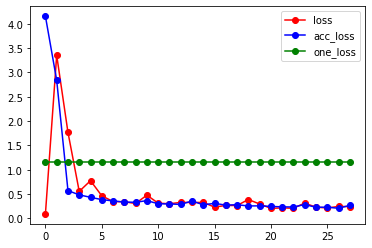

In [33]:
plt.plot(cum_losses, label='loss', color='red', marker='o')
plt.plot(acc_losses, label='acc_loss', color='blue', marker='o')
plt.plot(one_losses, label='one_loss', color='green', marker='o')
plt.legend()

In [34]:
#make test set and test
for length in range(4, 10):
    X, y = generate_data(length)
    print(X)
    print(y)
    X = torch.from_numpy(X)
    X = X.double()
    output = net(X)
    print("Length: ", length, " Output: ", output.item(), " Actual: ", y[-1])

[[0.50373761 0.        ]
 [0.51175497 1.        ]
 [0.71952303 0.        ]
 [0.90093691 1.        ]]
[0.         0.51175497 0.51175497 1.41269188]
Length:  4  Output:  1.0671953937561929  Actual:  1.4126918799097097
[[0.00808394 0.        ]
 [0.71390361 0.        ]
 [0.14481188 1.        ]
 [0.59389082 1.        ]
 [0.13230423 0.        ]]
[0.         0.         0.14481188 0.73870269 0.73870269]
Length:  5  Output:  0.8892867219507837  Actual:  0.7387026940955458
[[0.50353491 0.        ]
 [0.61889089 0.        ]
 [0.23242265 1.        ]
 [0.4063725  1.        ]
 [0.58411212 0.        ]
 [0.7813493  1.        ]]
[0.         0.         0.23242265 0.63879515 0.63879515 1.42014445]
Length:  6  Output:  1.4498547099774113  Actual:  1.4201444467842568
[[0.72329347 1.        ]
 [0.05758592 0.        ]
 [0.89015485 1.        ]
 [0.98846912 0.        ]
 [0.082057   0.        ]
 [0.64549622 0.        ]
 [0.64281661 0.        ]]
[0.72329347 0.72329347 1.61344832 1.61344832 1.61344832 1.61344832
 

In [35]:
loss = accuracy(net, X_test, y_test)
print(loss)

0.19204308730810085


In [36]:
loss_1 = one_accruacy(X_test, y_test)
print(loss_1)

1.1679290025941442
